# Jupyter Notebook per scaricare dati sismici con controllo dati esistenti

#### TASK:  

Scaricare i dati per il JNotebook UNIBO_TIP_02

### Import libraries

In [1]:
# Per la gestione dei file
import sys
import os

# Per il calcolo numerico
import numpy as np
from math import sqrt

# Per la presentazione grafica dei risultati
import matplotlib
import matplotlib.pyplot as plt

# Per l'analisi dei dati sismici (download compreso)
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import plot_travel_times

# Per le parti interattive del Notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets

#Per visualizzare immagini
from IPython.display import Image
import matplotlib.image as image 



### Definizioni

In [2]:
#############################################################################################
# EDIT HERE ---------- Set event parameters
#
EVENT_NAME="FERRARA_01"             # LABEL per i file creati
event_OT="2012-05-20T02:03:53.0"    # Tempo origine dell' evento
LAT=44.90                           # Approx longitudine dell' evento
LON=11.24                           # Approx latitudine dell' evento
MAX_DIST=100                        # Maximum distance in km from the event for downloading
#
#############################################################################################

# Stazioni sismiche
NET_CODE="IV"                                 # Nome del network di stazioni utilizzate (cercare in http://www.fdsn.org/networks/)

# Station files to be created
NAME_and_COORD_ALL_stations="input/stations_ALL_" + EVENT_NAME + ".dat"
NAME_and_COORD_SELE_stations="input/stations_check_OK_" + EVENT_NAME + ".dat"

print(' Selected event: ' + EVENT_NAME)

 Selected event: FERRARA_01


### Check data availability for the selected Time-Window

In [3]:
from obspy.clients.fdsn.header import URL_MAPPINGS
for key in sorted(URL_MAPPINGS.keys()):
    print("{0:<11} {1}".format(key,  URL_MAPPINGS[key]))
all_clients = list(URL_MAPPINGS.keys())
all_clients.remove('INGV')
all_clients = ['INGV'] + all_clients


AUSPASS     http://auspass.edu.au
BGR         http://eida.bgr.de
EIDA        http://eida-federator.ethz.ch
EMSC        http://www.seismicportal.eu
ETH         http://eida.ethz.ch
GEOFON      http://geofon.gfz-potsdam.de
GEONET      http://service.geonet.org.nz
GFZ         http://geofon.gfz-potsdam.de
ICGC        http://ws.icgc.cat
IESDMC      http://batsws.earth.sinica.edu.tw
INGV        http://webservices.ingv.it
IPGP        http://ws.ipgp.fr
IRIS        http://service.iris.edu
IRISPH5     http://service.iris.edu
ISC         http://isc-mirror.iris.washington.edu
KNMI        http://rdsa.knmi.nl
KOERI       http://eida.koeri.boun.edu.tr
LMU         http://erde.geophysik.uni-muenchen.de
NCEDC       https://service.ncedc.org
NIEP        http://eida-sc3.infp.ro
NOA         http://eida.gein.noa.gr
ODC         http://www.orfeus-eu.org
ORFEUS      http://www.orfeus-eu.org
RASPISHAKE  https://fdsnws.raspberryshakedata.com
RESIF       http://ws.resif.fr
RESIFPH5    http://ph5ws.resif.fr
SCEDC  

In [4]:
# Define parameters
starttime = UTCDateTime(event_OT)
endtime = starttime+600
net = NET_CODE
stn = "*"
channel = "HHZ"
count = 0
success = False
for cl in all_clients:
    try:
        print(f"--> Trying for client: {cl}")
        client = Client(cl)

        inventory = client.get_stations(network=net, station=stn, location="*", channel=channel,
                                        level="response", starttime=starttime, endtime=endtime)

        print(inventory)
        inventory.write(NAME_and_COORD_ALL_stations, 'STATIONTXT', level='station')
        success = True
        if success:
            break
    except KeyboardInterrupt:
        sys.exit()
    except:
        print(cl, sys.exc_info())
    count += 1
    
client_sele=cl
print('\n Selected Client: ', client_sele)

--> Trying for client: INGV
Inventory created at 2023-12-04T17:37:40.169000Z
	Created by: INGV-ONT WEB SERVICE: fdsnws-station | version: 1.1.57
		    /exist/apps/fdsn-station/fdsnws/station/1/query?starttime=2012-05-2...
	Sending institution: eXistDB (INGV-ONT)
	Contains:
		Networks (1):
			IV
		Stations (206):
			IV.ACER (Acerenza)
			IV.ALJA (Alia)
			IV.AMUR (Altamura)
			IV.AOI (Monte Conero)
			IV.ARCI (Arcidosso)
			IV.ARVD (ARCEVIA 2)
			IV.ASQU (Asqua)
			IV.ASSB (Assisi San Benedetto)
			IV.ATCA (Cantone)
			IV.ATFO (Monte Foce - Gubbio)
			IV.ATMI (AVT - Monte Miggiano)
			IV.ATPC (Poggio Castellaccio)
			IV.ATTE (AVT - Monte Tezio)
			IV.ATVO (AVT - Monte Valentino)
			IV.BDI (BAGNI DI LUCCA)
			IV.BOB (BOBBIO)
			IV.BRIS (BRISIGHELLA)
			IV.BRMO (BORMIO)
			IV.BSSO (Busso)
			IV.BULG (Bulgheria - Camerota)
			IV.CAAM (Accademia Aeronautica Pozzuoli)
			IV.CAFE (Carife)
			IV.CAFI (Castiglion Fiorentino)
			IV.CAFL (Arco Felice)
			IV.CAFR (Castel Frentano)
			IV.CAGR (Agir

## (1) Scaricare i dati sismici presenti nel database

In [5]:
STAT = []
STAT_INFO = []
stla = []
stlo = []
dist = []


statfile = open(NAME_and_COORD_ALL_stations, 'r')
linestoken=statfile.readlines()
istat=-1
for x in linestoken:
    if istat == -1:
        STAT_LIST_HEADER=x
    else:
        STAT.append(x.split("|")[1])
        stla.append(x.split("|")[2])
        stlo.append(x.split("|")[3])
        STAT_INFO.append(x.split("|")[0]+'|'+x.split("|")[1]+'|'+x.split("|")[2]+'|'+x.split("|")[3]+'|')
    istat += 1

    
Nstat=istat
print('Found:',Nstat,'seismic stations in file:',NAME_and_COORD_ALL_stations) 
istat=0
while istat < Nstat:
    stat0=STAT[istat]
    stla0=float(stla[istat])
    stlo0=float(stlo[istat])
    print('%6s%8s%10.3f%10.3f' % ('STAT:',stat0,stla0,stlo0))
    istat += 1
    


Found: 206 seismic stations in file: input/stations_ALL_FERRARA_01.dat
 STAT:    ACER    40.787    15.943
 STAT:    ALJA    37.749    13.754
 STAT:    AMUR    40.907    16.604
 STAT:     AOI    43.550    13.602
 STAT:    ARCI    42.852    11.475
 STAT:    ARVD    43.498    12.942
 STAT:    ASQU    43.797    11.789
 STAT:    ASSB    43.043    12.659
 STAT:    ATCA    43.566    12.266
 STAT:    ATFO    43.367    12.572
 STAT:    ATMI    43.334    12.268
 STAT:    ATPC    43.481    12.457
 STAT:    ATTE    43.198    12.354
 STAT:    ATVO    43.382    12.407
 STAT:     BDI    44.063    10.596
 STAT:     BOB    44.768     9.448
 STAT:    BRIS    44.225    11.767
 STAT:    BRMO    46.476    10.372
 STAT:    BSSO    41.546    14.594
 STAT:    BULG    40.078    15.378
 STAT:    CAAM    40.820    14.142
 STAT:    CAFE    41.028    15.237
 STAT:    CAFI    43.329    11.966
 STAT:    CAFL    40.844    14.094
 STAT:    CAFR    42.227    14.347
 STAT:    CAGR    37.622    14.500
 STAT:    CAMP    4

STATION: ACER too far: 596 km ... skip 
STATION: ALJA too far: 822 km ... skip 
STATION: AMUR too far: 622 km ... skip 
STATION: AOI too far: 240 km ... skip 
STATION: ARCI too far: 228 km ... skip 
STATION: ARVD too far: 206 km ... skip 
STATION: ASQU too far: 130 km ... skip 
STATION: ASSB too far: 235 km ... skip 
STATION: ATCA too far: 169 km ... skip 
STATION: ATFO too far: 200 km ... skip 
STATION: ATMI too far: 192 km ... skip 
STATION: ATPC too far: 185 km ... skip 
STATION: ATTE too far: 209 km ... skip 
STATION: ATVO too far: 192 km ... skip 
STATION: BDI too far: 106 km ... skip 
STATION: BOB too far: 142 km ... skip 
Station-sequence distance is: 85
       ... HHZ ...
       ...  HHZ done
       ... HHN ...
       ...  HHN done
       ... HHE ...
       ...  HHE done
 COMPLETED STATION: BRIS  -- This is the complete station number:  1
STATION: BRMO too far: 187 km ... skip 
STATION: BSSO too far: 461 km ... skip 
STATION: BULG too far: 634 km ... skip 
STATION: CAAM too far

       ...  HHZ done
       ... HHN ...
       ...  HHN done
       ... HHE ...
       ...  HHE done
 COMPLETED STATION: SALO  -- This is the complete station number:  6
STATION: SAMA too far: 363 km ... skip 
Station-sequence distance is: 30
       ... HHZ ...
       ...  HHZ done
       ... HHN ...
       ...  HHN done
       ... HHE ...
       ...  HHE done
 COMPLETED STATION: SBPO  -- This is the complete station number:  7
STATION: SCTE too far: 798 km ... skip 
STATION: SERS too far: 792 km ... skip 
STATION: SGG too far: 466 km ... skip 
STATION: SGRT too far: 504 km ... skip 
STATION: SGTA too far: 536 km ... skip 
STATION: SIRI too far: 646 km ... skip 
STATION: SLCN too far: 616 km ... skip 
STATION: SNAL too far: 547 km ... skip 
STATION: SNTG too far: 227 km ... skip 
STATION: SOLUN too far: 780 km ... skip 
STATION: SSFR too far: 203 km ... skip 
STATION: SSY too far: 918 km ... skip 
STATION: STAL too far: 189 km ... skip 
STATION: T0104 too far: 329 km ... skip 
Station-

/Library/Python/3.9/site-packages/obspy/io/mseed/core.py:821: UserWarning: File will be written with more than one different encodings.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'encodings')


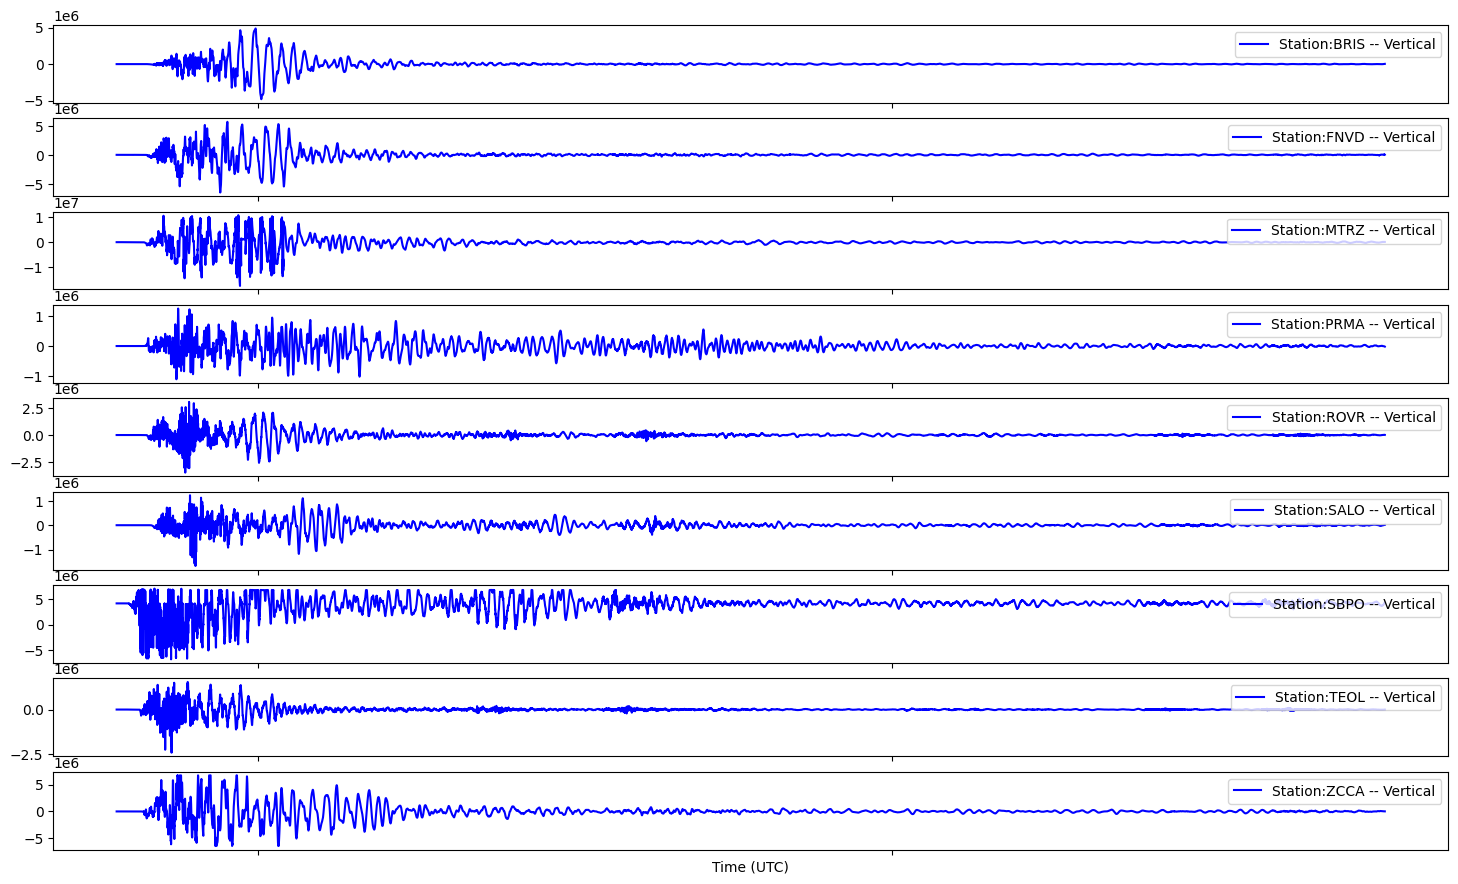

In [6]:
#
# Sezione del Notebook per scaricare i dati via WEB --- 
#
#
# Numer of seismogram components to be downloaded (1- Only Vertical; 3- Vertical + Horizontals)
n_comp= 3
#
#

client = Client(client_sele)
t = UTCDateTime(event_OT)

STAT_SELE = []
STAT_INFO_SELE = []
stla_sele = []
stlo_sele = []
Nstat_sele = 0
istat=0
while istat < Nstat:
    stat0=STAT[istat]
    info0=STAT_INFO[istat]
    stlo0=float(stlo[istat])
    stla0=float(stla[istat])
    dist0=int((obspy.taup.taup_geo.calc_dist(LAT,LON,stla0,stlo0,6371.0,0.0))*111.19)
    lab_DIST=str(dist0)
    # CHECK MAXIMUM DISTANCE FORM THE SEISMIC SEQUENCE
    if dist0 < MAX_DIST:
        print('Station-sequence distance is: ' + lab_DIST) 
        print('Downloading data for station:', stat0, ' ... ', istat, ' out of ', Nstat)
        icomp=0
        while icomp < n_comp:

            if icomp == 0:
                COMP_name="HHZ"
            if icomp == 1:
                COMP_name="HHN"
            if icomp == 2:
                COMP_name="HHE"

            print('       ... ' + COMP_name + ' ...')
            success = False
            try:
                st = client.get_waveforms(NET_CODE, stat0, "*", COMP_name, t, t + 600)
                # Check if MSEED has no gap
                if len(st.get_gaps()) == 0:
                    success = True
                else:
                    print('Found ' + COMP_name + ' trace with gaps ... skip the entire station')
                    icomp=999
                if success:
                    print('       ...  '+ COMP_name + ' done')
                    if icomp == 0:
                        st0=st.copy() 
                    if icomp == 1:
                        st1=st.copy() 
                    if icomp == 2:
                        st2=st.copy() 

            except:
                #print(stat0,sys.exc_info())
                print('------> No data Found for :', stat0, COMP_name)
                icomp=999

            icomp += 1  

        # Store three comp seismograms
        if success:
            Nstat_sele += 1
            STAT_SELE.append(stat0)
            STAT_INFO_SELE.append(info0)
            stla_sele.append(stla0)
            stlo_sele.append(stlo0)
            if Nstat_sele == 1:
                tr=st0.copy()
                if n_comp >1:
                    tr.append(st1[0])
                    tr.append(st2[0])
            else:
                tr.append(st0[0])
                if n_comp >1:
                    tr.append(st1[0])
                    tr.append(st2[0])


            print(' COMPLETED STATION:', stat0 , ' -- This is the complete station number: ', Nstat_sele)

    else:
        print('STATION: ' + stat0 + ' too far: ' + lab_DIST + ' km ... skip ')

    istat += 1


#Salvare i dati in formato MSEED
file_path = './data/' + EVENT_NAME + '.mseed'
tr.write(file_path, format='MSEED')
print(tr)

#Creare lista stazioni selezionate
istat=0
stat_file=open(NAME_and_COORD_SELE_stations,'w')
stat_file.write('%s' % (STAT_LIST_HEADER))
while istat < Nstat_sele:
    info0=STAT_INFO_SELE[istat]
    stat_file.write('%s\n' % (info0))
    istat += 1

# Flush file
stat_file.flush()







#
#
# Controllo segnali sismici scaricati/letti

fig_size=1.5*Nstat_sele
fig = plt.figure(figsize=(18, fig_size))

istat=0
while istat < Nstat_sele:
    tr0 = tr[(n_comp*istat)]
    stat0=STAT_SELE[istat]
    label0= 'Station:' + stat0 + ' -- Vertical'
    ax = fig.add_subplot(Nstat_sele+1, 1, istat+1)
    ax.plot(tr0.times("matplotlib"), tr0.data, "b-", label=label0)
    plt.legend(loc='upper right')
    ax.xaxis_date()
    fig.autofmt_xdate()
    istat += 1

plt.xlabel('Time (UTC)')    
plt.show()



####  Dove trovare altri terremoti:

https://www.emsc-csem.org/Earthquake/?filter=yes

In [ ]:
%load_ext watermark
%watermark -v -p numpy,matplotlib,obspy,ipywidgets